# Imbalanced datasets for classification

Examples are when the signal is very small relative to the background, like only 2%:
* fraud detection
* spam filtering
* medical diagnosis

https://www.analyticsvidhya.com/blog/2017/03/imbalanced-data-classification/

https://towardsdatascience.com/regression-for-imbalanced-data-with-application-edf93517247c

https://github.com/hananahmed1/ML-Regression-for-imbalaced-data/blob/master/UBR_application.R

https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18

https://towardsdatascience.com/how-to-deal-with-imbalanced-classification-without-re-balancing-the-data-8a3c02353fe3

https://machinelearningmastery.com/xgboost-for-imbalanced-classification/

Accuracy is wrong as a metric, as predicting no signal gives a 98% accuracy. Need metrics as precision, recall, F1 and confusion matrix.

First try to use `predict_proba` instead of `predict` and play with the threshold in the ROC style to find the best operating point.

Under-sampling or over-sampling techniques to be applied only on the train dataset. sklearn does it easily with the resample() method:
* over-sampling the minority class with replacement to the size of the majority class
* under-sampling the majority class without replacement to the size of the minority class

SMOTE using `from imblearn.over_sampling import SMOTE`

4 methods as above with code examples https://towardsdatascience.com/the-5-most-useful-techniques-to-handle-imbalanced-datasets-6cdba096d55a

# Resampling techniques

Re-sampling techniques to pre-process the data to reach about equal class A and B and not use weights:

### 1. Random under-sampling of the majority class

Advantage: the dataset becomes smaller, so it is faster to train. 

Disadvantages: information that is lost is potentially useful; the "random" chosen sample may be biased. Can lead to underfitting and poor generalization to the test set.

### 2. Random over-sampling of the minority class

Advantage: no information loss
Disadvantage: increases likelihood of over-fitting as the minority class appear several times

### 3. Cluster-based over-sampling

A k-means clustering algorithm is applied separately to both the majority and minority class. Each cluster is over-sampled in such a way as all clusters of the same class have an equal number of instances, and all classes have the same number of instances

### 4. Informed over-sampling: Syntethic Minority Over-Sampling Techniques (SMOTE)

Advantage: avoids overfitting when exact replicas of the minority class are added to the dataset (as in 2.) Here similar, but not identical (synthetic) datasets are produced and added to the dataset. But like 2. no loss of useful information. 

Disadvantage: Not consider neighbouring instances in the input phase space that actually belong to other classes. This can lead do noise.

### 5. Modified Synthetic Minority Over-Sampling Techniques (MSMOTE)

Solves from the problem of 4.

# Algorithmic Ensemble Techniques

Not change the sample, as above, but change the algorithm.

### 1. Bagging techniques

Bootstrap Aggregation (bagging) creates N boostrap samples with replacement. Training separately and aggregating the predictions at the end. 

Advantage: reduces overfitting and variance, improves misclassification rate, in noisy data outperforms boosting.
Disadvanage: Works well only if the base classifiers are not bad to start with. Bagging bad classifiers further degrades the performance.

### 2. Boosting techniques

Start with a weak learner that is further changed based on its performance, giving more weight to events that were not predicted well in the previous sample.

#### 2.1 Adaptive Boosting (AdaBoost)

First boosting technique created. 

Advantage: Simple to implement. Not prone to overfitting. Good generalization to any form of overfitting.

Disadvantage: Sensitive to noisy data and outliers. 

#### 2.2 Gradient Boosting 

It builds the first learner from the training dataset to predict the sample.
It calculates a loss function! It uses this loss to build and improved learner for the next stage.
At each step the residual of the loss function is calculated using the Gradient Descent Method. 
The new residual becomes a target variable for the subsequent iteration. 

Disadvantage: harder to fit than random forests. 

Need to fine-tune the key main hyper-parameters, or else it leads to over-training: shrinkange parameter, depth of trees and number of trees 

#### 2.3 Extreme Gradient Boosting (XGBoost)

A more efficient implementation of the Gradient Boosting method from 2.2. x10 faster as implements parallel processing. 

Flexible as can define custom optimization functions and evaluation criteria.

Has in inbuild mechanism of deadling with missing values.

unlike Gradient Boosting that stops splitting as soon as it hits a negative loss, XGBoost splits up to the specified maximum depth, then prunes tree backwards and removes splits with the negative loss. 

# Other ideas

Stratified sampling = ... (one suggests to first stratify and then split?)

Use weights, like in Random Forest use `class_weight = balanced`

https://towardsdatascience.com/how-to-deal-with-imbalanced-classification-without-re-balancing-the-data-8a3c02353fe3
    
    

# Code example of classification in a highly imbalanced dataset 

Using the Kaggle dataset on credit card fraud detection, with two classes.

https://www.kaggle.com/mlg-ulb/creditcardfraud/home

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn import metrics
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from imblearn.over_sampling import SMOTE

In [2]:
INPUT_FILE_NAME = "/Users/abuzatu/Work/data/finance/credit_card/creditcard.csv"

In [3]:
# logging level: NOTSET, DEBUG, INFO, WARNING, ERROR, CRITICAL
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [4]:
df = pd.read_csv(INPUT_FILE_NAME)
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [5]:
# very unblanced dataset
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [6]:
X = df.drop("Class", axis = 1)
X

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00


In [7]:
y = df.Class
y

0         0
1         0
2         0
3         0
4         0
         ..
284802    0
284803    0
284804    0
284805    0
284806    0
Name: Class, Length: 284807, dtype: int64

In [8]:
def check_train_test():
    #
    r = len(y_train)/len(y)
    d = y_train.value_counts().to_dict()
    ratio = d[1]/d[0]
    logging.info(f"train ratio to total dataset r = {r:.3f} and ratio S/B = {ratio:.6f}:")
    logging.info(f"\n{y_train.value_counts()}")
    #
    r = len(y_test)/len(y)
    d = y_test.value_counts().to_dict()
    ratio = d[1]/d[0]
    logging.info(f"test  ratio to total dataset r = {r:.3f} and ratio S/B = {ratio:.6f}:")
    logging.info(f"\n{y_test.value_counts()}")

# Naive way of setting up testing and training sets

but the ratio of S/B is not the same in both train and test

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, # X
    y, # y
    test_size = 0.25, # 75% in train, 25% in test
    random_state = 42)
check_train_test()

INFO:root:train ratio to total dataset r = 0.750 and ratio S/B = 0.001777:
INFO:root:
0    213226
1       379
Name: Class, dtype: int64
INFO:root:test  ratio to total dataset r = 0.250 and ratio S/B = 0.001590:
INFO:root:
0    71089
1      113
Name: Class, dtype: int64


# Better way of setting up testing and training sets

We have to be careful to have in each sample the same proportion of success/failure rates, or signal/background rates. Therefore it is not enough to divide randomly. But we want the ratio of S/B is the same in both train and test.

The trick is to use the option `stratify = df.y, # stratify`

Stratification ensures the same ratio of 1 to 0 in the target in the train and test datasets.

This is very important in highly unbalanced datasets. 

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, # X
    y, # y
    stratify = y, # stratify
    test_size = 0.25, # 75% in train, 25% in test
    random_state = 42)
check_train_test()

INFO:root:train ratio to total dataset r = 0.750 and ratio S/B = 0.001730:
INFO:root:
0    213236
1       369
Name: Class, dtype: int64
INFO:root:test  ratio to total dataset r = 0.250 and ratio S/B = 0.001730:
INFO:root:
0    71079
1      123
Name: Class, dtype: int64


# Resampling

Under-sampling or over-sampling techniques to be applied only on the train dataset. sklearn does it easily with the resample() method:
* over-sampling the minority class with replacement to the size of the majority class
* under-sampling the majority class without replacement to the size of the minority class

It must be done after the sample was split in train and test. And only applied to the train sample!

In [11]:
# first divide in train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, # X
    y, # y
    test_size = 0.25, # 75% in train, 25% in test
    random_state = 42)
check_train_test()

INFO:root:train ratio to total dataset r = 0.750 and ratio S/B = 0.001777:
INFO:root:
0    213226
1       379
Name: Class, dtype: int64
INFO:root:test  ratio to total dataset r = 0.250 and ratio S/B = 0.001590:
INFO:root:
0    71089
1      113
Name: Class, dtype: int64


In [12]:
# concatenate the training test together
df_train = pd.concat([X_train, y_train], axis = 1)
df_train

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
83225,59741.0,-1.648591,1.228130,1.370169,-1.735542,-0.029455,-0.484129,0.918645,-0.438750,0.982144,...,-0.218076,-0.203458,-0.213015,0.011372,-0.304481,0.632063,-0.262968,-0.099863,38.42,0
52800,45648.0,-0.234775,-0.493269,1.236728,-2.338793,-1.176733,0.885733,-1.960981,-2.363412,-2.694774,...,-1.495358,-0.083066,0.074612,-0.347329,0.541900,-0.433294,0.089293,0.212029,61.20,0
21293,31579.0,1.134626,-0.774460,-0.163390,-0.533358,-0.604555,-0.244482,-0.212682,0.040782,-1.136627,...,-0.684454,-1.855269,0.171997,-0.387783,-0.062985,0.245118,-0.061178,0.012180,110.95,0
133600,80455.0,0.069514,1.017753,1.033117,1.384376,0.223233,-0.310845,0.597287,-0.127658,-0.701533,...,0.097023,0.369957,-0.219266,-0.124941,-0.049749,-0.112946,0.114440,0.066101,10.00,0
38225,39302.0,-0.199441,0.610092,-0.114437,0.256565,2.290752,4.008475,-0.123530,1.038374,-0.075846,...,-0.019733,0.165463,-0.080978,1.020656,-0.300730,-0.269595,0.481769,0.254114,22.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,75618.0,1.173488,0.100792,0.490512,0.461596,-0.296377,-0.213165,-0.165254,0.119221,-0.114199,...,-0.186027,-0.574283,0.161405,-0.006140,0.091444,0.109235,-0.020922,0.003967,1.98,0
259178,159000.0,-0.775981,0.144023,-1.142399,-1.241113,1.940358,3.912076,-0.466107,1.360620,0.400697,...,0.037078,-0.019575,0.241830,0.682820,-1.635109,-0.770941,0.066006,0.137056,89.23,0
131932,79795.0,-0.146609,0.992946,1.524591,0.485774,0.349308,-0.815198,1.076640,-0.395316,-0.491303,...,0.052649,0.354089,-0.291198,0.402849,0.237383,-0.398467,-0.121139,-0.196195,3.94,0
146867,87931.0,-2.948638,2.354849,-2.521201,-3.798905,1.866302,2.727695,-0.471769,2.217537,0.580199,...,-0.332759,-1.047514,0.143326,0.678869,0.319710,0.426309,0.496912,0.335822,1.00,0


In [13]:
# separate in minority (signal, S) and majority (background, B) clsses
df_S = df_train[df_train.Class == 1]
df_B = df_train[df_train.Class == 0]
print(f"df_train shape={df_train.shape}")
print(f"df_S shape={df_S.shape}")
print(f"df_B shape={df_B.shape}")

df_train shape=(213605, 31)
df_S shape=(379, 31)
df_B shape=(213226, 31)


In [14]:
# under-sample (down-sample) the majority class.
# It must be without replacement, to remove an object once selected and not put it back (re-place).
# we give the number to be that of equal to the size of the minority sample
# the result is that some information was lost and it may be important
print(f"df_train shape={df_train.shape}")
print(f"df_S shape={df_S.shape}")
print(f"df_B shape={df_B.shape}")
df_B_down_sample = resample(df_B,
                            replace = False,
                            n_samples = len(df_S),
                            random_state = 42,
                           )
print(f"df_S shape={df_S.shape}")
print(f"df_B_down_sample shape={df_B_down_sample.shape}")
# concatenate the S and the B_down_sample together to create the new df_train
df_train_with_B_down_sample = pd.concat([df_B_down_sample, df_S], axis = 0)
print(f"df_train_with_B_down_sample shape={df_train_with_B_down_sample.shape}")

df_train shape=(213605, 31)
df_S shape=(379, 31)
df_B shape=(213226, 31)
df_S shape=(379, 31)
df_B_down_sample shape=(379, 31)
df_train_with_B_down_sample shape=(758, 31)


In [15]:
# over-sample (up-sample) the minority class.
# It must be with replacement, as otherwise we run out the samples.
# we give the number to be that of equal to the size of the majority sample
# the result is that the signal samples appear several times
print(f"df_train shape={df_train.shape}")
print(f"df_S shape={df_S.shape}")
print(f"df_B shape={df_B.shape}")
df_S_up_sample = resample(df_S,
                          replace = True,
                          n_samples = len(df_B),
                          random_state = 42,
                         )
print(f"df_S_up_sample shape={df_S_up_sample.shape}")
print(f"df_B shape={df_B.shape}")
# concatenate the S_up_sample and the B together to create the new df_train
df_train_with_S_up_sample = pd.concat([df_B, df_S_up_sample], axis = 0)
print(f"df_train_with_S_up_sample shape={df_train_with_S_up_sample.shape}")

df_train shape=(213605, 31)
df_S shape=(379, 31)
df_B shape=(213226, 31)
df_S_up_sample shape=(213226, 31)
df_B shape=(213226, 31)
df_train_with_S_up_sample shape=(426452, 31)


# Generate synthetic samples with SMOTE

The signal up-sampling has the problem that the exact same signal sample appear several times, which can lead to overfitting. We generate new samples that are similar, but not identical, to the signal sample.

Using the library `imbalance-learn` https://imbalanced-learn.org/stable/

https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [16]:
# first divide in train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, # X
    y, # y
    test_size = 0.25, # 75% in train, 25% in test
    random_state = 42)
check_train_test()

INFO:root:train ratio to total dataset r = 0.750 and ratio S/B = 0.001777:
INFO:root:
0    213226
1       379
Name: Class, dtype: int64
INFO:root:test  ratio to total dataset r = 0.250 and ratio S/B = 0.001590:
INFO:root:
0    71089
1      113
Name: Class, dtype: int64


In [17]:
# set up SMOTE
sm = SMOTE(random_state = 42)
sm

SMOTE(random_state=42)

In [18]:
# change the X_train and y_train and indded in train r > 1.0 and S/B is exactly 1.0; while test is not changed.
X_train, y_train = sm.fit_sample(X_train, y_train)
check_train_test()

INFO:root:train ratio to total dataset r = 1.497 and ratio S/B = 1.000000:
INFO:root:
1    213226
0    213226
Name: Class, dtype: int64
INFO:root:test  ratio to total dataset r = 0.250 and ratio S/B = 0.001590:
INFO:root:
0    71089
1      113
Name: Class, dtype: int64


# Without rebalancing data

https://towardsdatascience.com/how-to-deal-with-imbalanced-classification-without-re-balancing-the-data-8a3c02353fe3
    

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, # X
    y, # y
    stratify = y, # stratify
    test_size = 0.30, # 70% in train, 30% in test
    random_state = 42)
check_train_test()

INFO:root:train ratio to total dataset r = 0.700 and ratio S/B = 0.001728:
INFO:root:
0    199020
1       344
Name: Class, dtype: int64
INFO:root:test  ratio to total dataset r = 0.300 and ratio S/B = 0.001735:
INFO:root:
0    85295
1      148
Name: Class, dtype: int64


In [27]:
# create a model from sklearn
gbc = HistGradientBoostingClassifier(
    learning_rate = 0.01, # hyper-parameter to tune
    max_iter = 2000,
    max_leaf_nodes = 6, # hyper-parameter to tune
    validation_fraction = 0.2, 
    n_iter_no_change = 15, # to stop the training early if the performance on a validation subset starts to deteriorate due to overfitting
    random_state = 42)
gbc

HistGradientBoostingClassifier(learning_rate=0.01, max_iter=2000,
                               max_leaf_nodes=6, n_iter_no_change=15,
                               random_state=42, validation_fraction=0.2)

In [29]:
# train
gbc.fit(X_train, y_train)

HistGradientBoostingClassifier(learning_rate=0.01, max_iter=2000,
                               max_leaf_nodes=6, n_iter_no_change=15,
                               random_state=42, validation_fraction=0.2)

In [30]:
# predict on test
# this assumes the 0.5 threshold, >= -0.5 is positive, < 0.5 is negative
y_predicted_test = gbc.predict(X_test)

In [33]:
# confusion matrix
def conf_matrix(y, pred):
    ((tn, fp), (fn, tp)) = metrics.confusion_matrix(y, pred)
    ((tnr,fpr),(fnr,tpr))= metrics.confusion_matrix(y, pred, 
            normalize='true')
    return pd.DataFrame([[f'TN = {tn} (TNR = {tnr:1.2%})', 
                                f'FP = {fp} (FPR = {fpr:1.2%})'], 
                         [f'FN = {fn} (FNR = {fnr:1.2%})', 
                                f'TP = {tp} (TPR = {tpr:1.2%})']],
            index=['True 0 (Legit)', 'True 1 (Fraud)'], 
            columns=['Pred 0 (Approve as Legit)', 
                            'Pred 1 (Deny as Fraud)'])

In [36]:
conf_matrix(y_test, y_predicted_test)

,Pred 0( Approve as Legit),Pred 1 (Deny as Fraud)
True 0 (Legit),TN = 85284 (TNR = 99.99%),FP = 11 (FPR = 0.01%)
True 1 (Fraud),FN = 40 (FNR = 27.03%),TP = 108 (TPR = 72.97%)


In [37]:
108/(108+11) # precision

0.907563025210084

In [38]:
108/(108+40) # recall, or True Positive Rate, or TPR

0.7297297297297297

In [39]:
40/(108+40) # False Negative Rate (FNR) - Type I error

0.2702702702702703

In [40]:
85284 / (85284+11) # True Negative Rate (TNR)

0.9998710358168709

In [41]:
11 / (85284+11) # False Positive Rate (FPR) - Type 2 error

0.00012896418312914005

Let's vary the threshold instead of 0.5 and see how the FP and FN change. There is a trade-off. Find a balance.

It is like a Receiving Operating Curve (ROC) curve, but changed.

We plot the False Positive Rate (FPR, or Type II error) and False Negative Rate (FNR, or Type O error).

Both type of errors can not be zero at the same time. There is a trade-off.

Business needs will decide the balance, or trade-off version.

Use instead of `predict()` the method `predict_proba()`, or predict the probability. If your model does not have this function, use its decision function instead.

In [78]:
# predict the probability
y_predicted_proba_test = gbc.predict_proba(X_test)

In [79]:
y_predicted_proba_test

array([[9.99994660e-01, 5.33966139e-06],
       [9.99935122e-01, 6.48780379e-05],
       [9.99788878e-01, 2.11121562e-04],
       ...,
       [9.99990972e-01, 9.02846156e-06],
       [9.99937942e-01, 6.20582725e-05],
       [9.99984961e-01, 1.50388011e-05]])

In [80]:
y_predicted_proba_test.shape

(85443, 2)

In [81]:
# note we want to use only one dimension so this
y_predicted_proba_test[:, 1]

array([5.33966139e-06, 6.48780379e-05, 2.11121562e-04, ...,
       9.02846156e-06, 6.20582725e-05, 1.50388011e-05])

In [83]:
# so let's incorporate directly 
y_predicted_proba_test = gbc.predict_proba(X_test)[:, 1]
y_predicted_proba_test

array([5.33966139e-06, 6.48780379e-05, 2.11121562e-04, ...,
       9.02846156e-06, 6.20582725e-05, 1.50388011e-05])

In [85]:
# ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predicted_proba_test)

In [86]:
fpr

array([0.        , 0.        , 0.        , ..., 0.99980069, 0.99987104,
       1.        ])

In [87]:
tpr

array([0.        , 0.00675676, 0.07432432, ..., 1.        , 1.        ,
       1.        ])

In [88]:
thresholds

array([1.99885239e+00, 9.98852390e-01, 9.95476121e-01, ...,
       9.61058764e-07, 9.28484349e-07, 5.26525070e-07])

In [89]:
fpr.shape

(7000,)

In [90]:
tpr.shape

(7000,)

In [91]:
thresholds.shape

(7000,)

,Threshold,False Positive Rate,False Negative Rate
0,1.998852e+00,0.000000,1.000000
1,9.988524e-01,0.000000,0.993243
2,9.954761e-01,0.000000,0.925676
3,9.950777e-01,0.000000,0.912162
4,9.738802e-01,0.000000,0.601351
...,...,...,...
6995,1.033531e-06,0.999355,0.000000
6996,1.025276e-06,0.999766,0.000000
6997,9.610588e-07,0.999801,0.000000
6998,9.284843e-07,0.999871,0.000000


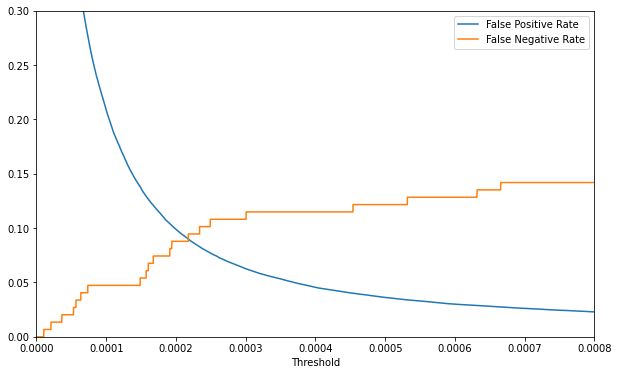

In [92]:
def plot_fpr_tpr_vs_threshold():
    df_plot = pd.DataFrame(
        {
            "Threshold" : thresholds, 
            "False Positive Rate" : fpr, 
            "False Negative Rate" : 1.-tpr,
        }
    )
    ax = df_plot.plot(
        x = "Threshold",
        y = ["False Positive Rate", "False Negative Rate"],
        figsize = (10, 6),
    )
    ax.set_xbound(0, 0.0008)
    ax.set_ybound(0, 0.3)
    return df_plot
df_plot = plot_fpr_tpr_vs_threshold()
df_plot

Choose threshold where the two false rates are about equal, say 0.00035.

(array([8.5292e+04, 1.5000e+01, 6.0000e+00, 7.0000e+00, 4.0000e+00,
        6.0000e+00, 5.0000e+00, 3.0000e+00, 7.0000e+00, 9.8000e+01]),
 array([5.26525070e-07, 9.98857128e-02, 1.99770899e-01, 2.99656085e-01,
        3.99541272e-01, 4.99426458e-01, 5.99311644e-01, 6.99196831e-01,
        7.99082017e-01, 8.98967203e-01, 9.98852390e-01]),
 <BarContainer object of 10 artists>)

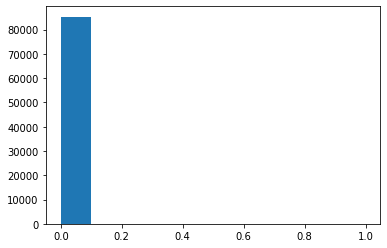

In [93]:
plt.hist(y_predicted_proba_test, bins = 10)

In [74]:
y_predicted_proba_test[:, 1]

array([5.33966139e-06, 6.48780379e-05, 2.11121562e-04, ...,
       9.02846156e-06, 6.20582725e-05, 1.50388011e-05])

In [75]:
np.max(y_predicted_proba_test)

0.9988523896934093

In [98]:
# if bigger than thrshold, set 1, if smaller, set zero
threshold = 0.00035
y_predicted_threshold_test = np.where(y_predicted_proba_test > threshold, 1, 0)
y_predicted_threshold_test

array([0, 0, 0, ..., 0, 0, 0])

In [99]:
# calculate again the confusion matrix
conf_matrix(y_test, y_predicted_threshold_test)

,Pred 0( Approve as Legit),Pred 1 (Deny as Fraud)
True 0 (Legit),TN = 80752 (TNR = 94.67%),FP = 4543 (FPR = 5.33%)
True 1 (Fraud),FN = 17 (FNR = 11.49%),TP = 131 (TPR = 88.51%)


In [100]:
# remind us the original one
conf_matrix(y_test, y_predicted_test)

,Pred 0( Approve as Legit),Pred 1 (Deny as Fraud)
True 0 (Legit),TN = 85284 (TNR = 99.99%),FP = 11 (FPR = 0.01%)
True 1 (Fraud),FN = 40 (FNR = 27.03%),TP = 108 (TPR = 72.97%)
